# Supervised Fine-Tuning (SFT) with Full Rank Finetuning(FFT) of Amazon Nova using Amazon SageMaker Training Job

You can customize Amazon Nova models through base recipes using Amazon SageMaker training jobs. These recipes support Supervised Fine-Tuning (SFT) and Direct Preference Optimization (DPO), with both Full-Rank and Low-Rank Adaptation (LoRA) options.

The end-to-end customization workflow involves stages like model training, model evaluation, and deployment for inference. This model customization approach on SageMaker AI provides greater flexibility and control to fine-tune its supported Amazon Nova models, optimize hyperparameters with precision, and implement techniques including LoRA Parameter-Efficient Fine-Tuning (PEFT), Full-Rank Supervised Fine-Tuning, and Direct Preference Optimization (DPO).

This notebook demonstrates Supervised Fine-Tuning (SFT) with Full Rank fine tuning of Amazon Nova using Amazon SageMaker Training Job. SFT is a technique that allows fine-tuning language models on specific tasks using labeled examples, enabling the model to learn from human-generated examples.


> _**Note:** This notebook demonstrates fine-tuning using Nova Lite, but the same techniques can be applied to Nova Pro or Nova Micro models with appropriate adjustments to the configuration.

## Installing Dependencies


The first cell installs the required Python packages for this notebook. For more details on other pre-requisites needed check out [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/nova-model-general-prerequisites.html)

In [1]:
! pip install -r ./requirements.txt --upgrade

Processing ./sagemaker-2.245.1.dev0.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sagemaker: filename=sagemaker-2.245.1.dev0-py3-none-any.whl size=1651861 sha256=a3200be025a9fd1e2aba119b05d84e5372ca6ffa71734d74198a911e63ebdbe6
  Stored in directory: /home/ec2-user/.cache/pip/wheels/df/ad/4f/d0e921991270f56ea2eb5a16205186ec9076ae1f25fa66df41
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.245.1.dev0
    Uninstalling sagemaker-2.245.1.dev0:
      Successfully uninstalled sagemaker-2.245.1.dev0


***

## Step 0: Prerequisites

This section sets up the necessary AWS credentials and SageMaker session to run the notebook. You'll need proper IAM permissions to use SageMaker.


If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.

The code initializes a SageMaker session, sets up the IAM role, and configures the S3 bucket for storing training data and model artifacts.


In [ ]:
import sagemaker
import boto3

sess = sagemaker.Session()
sagemaker_session_bucket = None

if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client("iam")
    role = iam.get_role(RoleName="sagemaker_execution_role")["Role"]["Arn"]

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)
bucket_name = sess.default_bucket()
default_prefix = sess.default_bucket_prefix

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/dewanup/Library/Application Support/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::905418197933:role/NovaCustomizationRole
sagemaker bucket: sagemaker-us-east-1-905418197933
sagemaker session region: us-east-1


### Full Rank Finetuning
Full-rank fine-tuning modifies all parameters of the foundation model to optimize its performance for specific tasks or domains. This comprehensive approach updates the entire model architecture, enabling deeper adaptations than adapter-based methods.

### How it works
During full-rank fine-tuning, the model learns by updating all its parameters using your training data. This process:
• Allows the model to develop specialized knowledge for your domain
• Enables significant changes to the model’s underlying representations
• Requires more computational resources but can achieve better task-specific performance

### When to choose full-rank fine-tuning
We recommend full-rank fine-tuning in these scenarios:
• When LoRA fine-tuning doesn’t achieve desired performance levels
• For specialized domains requiring deep expertise (e.g., medical, legal, or technical fields)
• When you have large, high-quality datasets specific to your use case
• When accuracy requirements outweigh computational cost considerations
• For applications requiring significant deviation from the base model’s behavior
Note that full-rank fine-tuning requires more computational resources and training time compared to adapter-based methods, but it can provide superior results for specialized applications.

![imgs/fft_arch.png](imgs/fft_arch.png)


***

## Step 1: Prepare the dataset

In this example, we are going to load [glaiveai/glaive-function-calling-v2](https://huggingface.co/datasets/glaiveai/glaive-function-calling-v2) dataset, an open-source dataset and model suite focused on enabling and improving function calling capabilities for large language models (LLMs)

### Step 1.1: Data Loading

This code loads the first 10,000 examples from the glaive-function-calling-v2 dataset from Hugging Face.


In [2]:
from datasets import load_dataset

dataset = load_dataset("glaiveai/glaive-function-calling-v2", split="train[:10000]")

dataset

Dataset({
    features: ['system', 'chat'],
    num_rows: 10000
})

Converting the dataset to a pandas DataFrame makes it easier to work with and manipulate.


In [3]:
from utils.preprocessing import glaive_to_standard_format

processed_dataset = glaive_to_standard_format(dataset)

In [4]:
import pandas as pd

df = pd.DataFrame(processed_dataset)

df.head()

,system,chat,messages,tools
0,SYSTEM: You are a helpful assistant with acces...,USER: Can you book a flight for me from New Yo...,"[{'content': 'You are a helpful assistant.', '...","[{""type"": ""function"", ""function"": {""name"": ""ge..."
1,SYSTEM: You are a helpful assistant with acces...,USER: Can you tell me the latest news headline...,"[{'content': 'You are a helpful assistant.', '...","[{""type"": ""function"", ""function"": {""name"": ""ge..."
2,SYSTEM: You are a helpful assistant with acces...,USER: I need a new password. Can you generate ...,"[{'content': 'You are a helpful assistant.', '...","[{""type"": ""function"", ""function"": {""name"": ""ge..."
3,SYSTEM: You are a helpful assistant with acces...,USER: I need a new password. Can you generate ...,"[{'content': 'You are a helpful assistant.', '...","[{""type"": ""function"", ""function"": {""name"": ""ge..."
4,SYSTEM: You are a helpful assistant with acces...,"USER: Hi, I have a list of numbers and I need ...","[{'content': 'You are a helpful assistant.', '...","[{""type"": ""function"", ""function"": {""name"": ""ca..."


### Step 1.2: Train/Val/Test Split

The dataset is split into training (72%), validation (18%), and test (10%) sets to properly evaluate the model. 

In [5]:
from sklearn.model_selection import train_test_split

temp, test = train_test_split(df, test_size=0.1, random_state=42)
train, val = train_test_split(temp, test_size=0.2, random_state=42)

print("Number of train elements: ", len(train))
print("Number of test elements: ", len(test))
print("Number of val elements: ", len(val))

Number of train elements:  7178
Number of test elements:  998
Number of val elements:  1795


### Understanding the Nova Format

Let's format the dataset by using the prompt style for Amazon Nova:

```
{
    "system": [{"text": Content of the System prompt}],
    "messages": [
        {
            "role": "user",
            "content": ["text": Content of the user prompt]
        },
        {
            "role": "assistant",
            "content": ["text": Content of the answer]
        },
        ...
    ]
}
```

### Step 1.3: Data Preprocessing 

The notebook defines utility functions to clean the dataset content by removing prefixes and handling special cases:

```python
def clean_prefix(content):
    # Removes prefixes like "USER:", "ASSISTANT:", etc.
    ...

def clean_message_list(message_list):
    # Cleans message lists from None values and converts to proper format
    ...

def clean_numbered_conversation(message_list):
    # Cleans message lists from None values and converts to proper format
    ...
```

In [6]:
import json
import re


def clean_prefix(content):
    """Remove prefixes from content, according to Nova data_validator"""
    prefixes = [
        "SYSTEM:",
        "System:",
        "USER:",
        "User:",
        "ASSISTANT:",
        "Assistant:",
        "Bot:",
        "BOT:",
    ]

    # Handle array case (list of content items)
    if hasattr(content, "__iter__") and not isinstance(content, str):
        for i, item in enumerate(content):
            if isinstance(item, dict) and "text" in item:
                text = item["text"]
                if isinstance(text, str):
                    # Clean line by line for multi-line text
                    lines = text.split("\n")
                    cleaned_lines = []
                    for line in lines:
                        cleaned_line = line.strip()
                        for prefix in prefixes:
                            if cleaned_line.startswith(prefix):
                                cleaned_line = cleaned_line[len(prefix) :].strip()
                                break
                        cleaned_lines.append(cleaned_line)
                    item["text"] = "\n".join(cleaned_lines)
        return content

    # Handle string case
    if isinstance(content, str):
        lines = content.split("\n")
        cleaned_lines = []
        for line in lines:
            cleaned_line = line.strip()
            for prefix in prefixes:
                if cleaned_line.startswith(prefix):
                    cleaned_line = cleaned_line[len(prefix) :].strip()
                    break
            cleaned_lines.append(cleaned_line)
        return "\n".join(cleaned_lines)

    return content


def clean_message_list(message_list):
    """Clean message list from None values and convert to list of dicts if needed."""
    if isinstance(message_list, str):
        message_list = json.loads(message_list)

    tmp_cleaned = []
    for msg in message_list:
        new_msg = {}
        for key, value in msg.items():
            if key in ["content"]:
                if value is None or str(value).lower() == "None":
                    continue
            new_msg[key] = value
        tmp_cleaned.append(new_msg)

    cleaned = []
    for item in tmp_cleaned:
        content = item["content"]
        for content_item in content:
            if isinstance(content_item, dict) and "text" in content_item:
                text = clean_numbered_conversation(content_item["text"])
                content_item["text"] = clean_prefix(text)
        cleaned.append({"role": item["role"], "content": content})

    return cleaned


# Additional function to specifically handle the numbered conversation format
def clean_numbered_conversation(text):
    """Clean numbered conversation format like '1. User: ...'"""
    if not isinstance(text, str):
        return text

    # Pattern to match numbered items with User: or Assistant: prefixes
    pattern = r"(\d+\.\s*)(User:|Assistant:)\s*"

    # Replace the pattern, keeping the number but removing the role prefix
    cleaned_text = re.sub(pattern, r"\1", text)

    return cleaned_text


These functions transform the dataset into the format required by Nova models, handling tool calls and formatting:

```python

def transform_tool_format(tool):
    # Transforms tool format to Nova's expected format
    ...

def prepare_dataset(sample):
    # Prepares dataset in the required format for Nova models
    ...

def prepare_dataset_test(sample):
    # Formats validation dataset for evaluation
    ...
```


In [7]:
import json

def transform_tool_format(tool):
    """Transform tool from old format to Nova format."""
    if "function" not in tool:
        return tool

    function = tool["function"]
    return {
        "toolSpec": {
            "name": function["name"],
            "description": function["description"],
            "inputSchema": {"json": function["parameters"]},
        }
    }


def prepare_dataset(sample):
    """Prepare dataset in the required format for Nova models"""
    messages = {"system": [], "messages": []}

    # Process tools upfront if they exist
    tools = json.loads(sample["tools"]) if sample.get("tools") else []
    transformed_tools = [transform_tool_format(tool) for tool in tools]

    formatted_text = (
        ""  # Initialize outside the loop to avoid undefined variable issues
    )

    for message in sample["messages"]:
        role = message["role"]

        if role == "system" and tools:
            # Build system message with tools
            system_text = (
                f"{message['content']}\n"
                "You may call one or more functions to assist with the user query.\n\n"
                "You are provided with function signatures within <tools></tools> XML tags:\n"
                "<tools>\n"
                f"{json.dumps({'tools': transformed_tools})}\n"
                "</tools>\n\n"
                "For each function call, return a json object with function name and parameters:\n"
                '{"name": function name, "parameters": dictionary of argument name and its value}'
            )
            messages["system"] = [{"text": system_text.lower()}]

        elif role == "user":
            messages["messages"].append(
                {"role": "user", "content": [{"text": message["content"].lower()}]}
            )

        elif role == "tool":
            formatted_text += message["content"]
            messages["messages"].append(
                {"role": "user", "content": [{"text": formatted_text.lower()}]}
            )

        elif role == "assistant":
            if message.get("tool_calls"):
                # Process tool calls
                tool_calls_text = []
                for tool_call in message["tool_calls"]:
                    function_data = tool_call["function"]
                    arguments = (
                        json.loads(function_data["arguments"])
                        if isinstance(function_data["arguments"], str)
                        else function_data["arguments"]
                    )
                    tool_call_json = {
                        "name": function_data["name"],
                        "parameters": arguments,
                    }
                    tool_calls_text.append(json.dumps(tool_call_json))

                messages["messages"].append(
                    {
                        "role": "assistant",
                        "content": [{"text": "".join(tool_calls_text)}],
                    }
                )
            else:
                messages["messages"].append(
                    {"role": "assistant", "content": [{"text": message["content"].lower()}]}
                )

    # Remove the last message if it's not from assistant
    if messages["messages"] and messages["messages"][-1]["role"] != "assistant":
        messages["messages"].pop()

    return messages

In [8]:
def prepare_dataset_test(sample):
    """Parse sample and format it for validation dataset."""
    # Process tools
    tools = json.loads(sample["tools"]) if sample.get("tools") else []
    transformed_tools = [transform_tool_format(tool) for tool in tools]

    # Initialize result
    result = []
    conversation_history = []

    # Extract system message
    system_content = ""
    for message in sample["messages"]:
        if message["role"] == "system":
            system_content = message["content"]
            if tools:
                system_content += (
                    "\nYou may call one or more functions to assist with the user query.\n\n"
                    "You are provided with function signatures within <tools></tools> XML tags:\n"
                    "<tools>\n"
                    f"{json.dumps({'tools': transformed_tools})}\n"
                    "</tools>\n\n"
                    "For each function call, return a json object with function name and parameters:\n"
                    '{"name": function name, "parameters": dictionary of argument name and its value}'
                )
            break

    # Process conversation turns
    for i, message in enumerate(sample["messages"]):
        if message["role"] == "system":
            continue

        # Add message to conversation history
        if message["role"] == "user":
            conversation_history.append(f"##User: {message['content']}")
        elif message["role"] == "assistant":
            if message.get("tool_calls"):
                # Format tool calls
                target_parts = []
                for tool_call in message["tool_calls"]:
                    function_data = tool_call["function"]
                    arguments = (
                        json.loads(function_data["arguments"])
                        if isinstance(function_data["arguments"], str)
                        else function_data["arguments"]
                    )
                    target_parts.append(
                        json.dumps(
                            {"name": function_data["name"], "parameters": arguments}
                        )
                    )
                target = "".join(target_parts)

                conversation_history.append(f"##Assistant: {target}")
            else:
                conversation_history.append(f"##Assistant: {message['content']}")
        elif message["role"] == "tool":
            conversation_history.append(f"## Function: {message['content']}")

        # Create input-target pair when we have an assistant message
        if message["role"] == "assistant":
            # Input is system message + all previous conversation
            input_text = "\n".join(conversation_history[:-1])

            # Target is the assistant's response
            if message.get("tool_calls"):
                # Format tool calls
                target_parts = []
                for tool_call in message["tool_calls"]:
                    function_data = tool_call["function"]
                    arguments = (
                        json.loads(function_data["arguments"])
                        if isinstance(function_data["arguments"], str)
                        else function_data["arguments"]
                    )
                    target_parts.append(
                        json.dumps(
                            {"name": function_data["name"], "parameters": arguments}
                        )
                    )
                target = "".join(target_parts)
            else:
                target = message["content"]

            result.append(
                {"system": system_content, "query": input_text, "response": target}
            )

    return {"messages": result}

### Step 1.4: Data Preperation in Converse Format for Train and Validation Datasets

In [9]:
from datasets import Dataset, DatasetDict
from random import randint

train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(val)
test_dataset = Dataset.from_pandas(test)


dataset = DatasetDict(
    {"train": train_dataset, "test": test_dataset, "val": val_dataset}
)

train_dataset = dataset["train"].map(
    prepare_dataset, remove_columns=train_dataset.features
)

train_dataset = train_dataset.to_pandas()

train_dataset["messages"] = train_dataset["messages"].apply(clean_message_list)

print(train_dataset.iloc[randint(0, len(train_dataset))].to_json())

val_dataset = dataset["val"].map(prepare_dataset, remove_columns=val_dataset.features)

val_dataset = val_dataset.to_pandas()

val_dataset["messages"] = val_dataset["messages"].apply(clean_message_list)

print(val_dataset.iloc[randint(0, len(val_dataset))].to_json())

test_dataset = dataset["test"].map(
    prepare_dataset_test, remove_columns=test_dataset.features
)
print(test_dataset[randint(0, len(test_dataset))])

Map:   0%|          | 0/7178 [00:00<?, ? examples/s]

{"system":[{"text":"you are a helpful assistant.\nyou may call one or more functions to assist with the user query.\n\nyou are provided with function signatures within <tools><\/tools> xml tags:\n<tools>\n{\"tools\": [{\"toolspec\": {\"name\": \"calculate_area\", \"description\": \"calculate the area of a geometric shape\", \"inputschema\": {\"json\": {\"type\": \"object\", \"properties\": {\"shape\": {\"type\": \"string\", \"description\": \"the shape to calculate the area of (e.g. circle, triangle, rectangle)\"}, \"dimensions\": {\"type\": \"object\", \"description\": \"the dimensions required to calculate the area of the specified shape\"}}, \"required\": [\"shape\", \"dimensions\"]}}}}, {\"toolspec\": {\"name\": \"calculate_age\", \"description\": \"calculate the age based on birthdate\", \"inputschema\": {\"json\": {\"type\": \"object\", \"properties\": {\"birthdate\": {\"type\": \"string\", \"description\": \"the birthdate in yyyy-mm-dd format\"}}, \"required\": [\"birthdate\"]}}

Map:   0%|          | 0/1795 [00:00<?, ? examples/s]

{"system":[{"text":"you are a helpful assistant.\nyou may call one or more functions to assist with the user query.\n\nyou are provided with function signatures within <tools><\/tools> xml tags:\n<tools>\n{\"tools\": [{\"toolspec\": {\"name\": \"send_email\", \"description\": \"send an email to a recipient\", \"inputschema\": {\"json\": {\"type\": \"object\", \"properties\": {\"recipient_email\": {\"type\": \"string\", \"description\": \"the email address of the recipient\"}, \"subject\": {\"type\": \"string\", \"description\": \"the subject of the email\"}, \"message\": {\"type\": \"string\", \"description\": \"the content of the email\"}}, \"required\": [\"recipient_email\", \"subject\", \"message\"]}}}}, {\"toolspec\": {\"name\": \"generate_qr_code\", \"description\": \"generate a qr code for a given text\", \"inputschema\": {\"json\": {\"type\": \"object\", \"properties\": {\"text\": {\"type\": \"string\", \"description\": \"the text to be encoded in the qr code\"}, \"size\": {\"ty

Map:   0%|          | 0/998 [00:00<?, ? examples/s]

{'messages': [{'query': '##User: I need a random number between 1 and 100.', 'response': '{"name": "generate_random_number", "parameters": {"min": 1, "max": 100}}', 'system': 'You are a helpful assistant.\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>\n{"tools": [{"toolSpec": {"name": "generate_random_number", "description": "Generate a random number", "inputSchema": {"json": {"type": "object", "properties": {"min": {"type": "number", "description": "The minimum value for the random number"}, "max": {"type": "number", "description": "The maximum value for the random number"}}, "required": ["min", "max"]}}}}, {"toolSpec": {"name": "create_calendar_event", "description": "Create a new event in the calendar", "inputSchema": {"json": {"type": "object", "properties": {"title": {"type": "string", "description": "The title of the event"}, "date": {"type": "string", "description": "The da

### Step 1.5: Data Preperation on test data for Offline Evaluation post fine tuning

Let's format the test dataset in the format:

Required Fields:

* query: String containing the question or instruction that needs an answer
* response: String containing the expected model output

Optional Fields:

* system: String containing the system prompt that sets the behavior, role, or personality of the AI model before it processes the query

Example Entry
```

{
   "system":"You are a english major with top marks in class who likes to give minimal word responses: ",
   "query":"What is the symbol that ends the sentence as a question",
   "response":"?"
}
{
   "system":"You are a pattern analysis specialist that provides succinct answers: ",
   "query":"What is the next number in this series? 1, 2, 4, 8, 16, ?",
   "response":"32"
}
{
   "system":"You have great attention to detail that follows instructions accurately: ",
   "query":"Repeat only the last two words of the following: I ate a hamburger today and it was kind of dry",
   "response":"of dry"
}
```

In [10]:
from datasets import Dataset

# Flatten the dataset
all_examples = []
for examples_list in test_dataset:
    # The first column contains the list of examples
    column_name = test_dataset.column_names[0]
    examples = examples_list[column_name]
    all_examples.extend(examples)

# Create a new dataset with the desired structure
test_dataset = Dataset.from_dict(
    {
        "system": [example["system"] for example in all_examples],
        "query": [example["query"] for example in all_examples],
        "response": [example["response"] for example in all_examples],
    }
)

print(test_dataset[randint(0, len(val_dataset))])

{'system': 'You are a helpful assistant.\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>\n{"tools": [{"toolSpec": {"name": "calculate_tip", "description": "Calculate the tip amount for a given bill", "inputSchema": {"json": {"type": "object", "properties": {"bill_amount": {"type": "number", "description": "The bill amount"}, "tip_percentage": {"type": "number", "description": "The tip percentage"}}, "required": ["bill_amount", "tip_percentage"]}}}}]}\n</tools>\n\nFor each function call, return a json object with function name and parameters:\n{"name": function name, "parameters": dictionary of argument name and its value}', 'query': '##User: Hi, I need help with calculating the tip for my bill. The total bill is $50 and I want to leave a 15% tip.\n##Assistant: {"name": "calculate_tip", "parameters": {"bill_amount": 50, "tip_percentage": 15}}\n## Function: {"tip_amount": 7.5}\n##Ass

### Step 1.6: Upload all 3 curated datasets (train, test, val) to Amazon S3

The notebook applies the functions to transform the datasets into the required formats


The processed datasets are saved locally and then uploaded to Amazon S3 for use in SageMaker training:



In [11]:
import boto3
import shutil

In [12]:
s3_client = boto3.client('s3')

# save train_dataset to s3 using our SageMaker session
if default_prefix:
    input_path = f"{default_prefix}/datasets/nova-sft-peft"
else:
    input_path = f"datasets/nova-sft-peft"

train_dataset_s3_path = f"s3://{bucket_name}/{input_path}/train/dataset.jsonl"
val_dataset_s3_path = f"s3://{bucket_name}/{input_path}/val/dataset.jsonl"
test_dataset_s3_path = f"s3://{bucket_name}/{input_path}/test/gen_qa.jsonl"

In [13]:
import os

# Save datasets to s3
os.makedirs("./data/train", exist_ok=True)
os.makedirs("./data/val", exist_ok=True)

train_dataset.to_json("./data/train/dataset.jsonl", orient="records", lines=True)
val_dataset.to_json("./data/val/dataset.jsonl", orient="records", lines=True)
test_dataset.to_json("./data/test/gen_qa.jsonl")

s3_client.upload_file(
    "./data/train/dataset.jsonl", bucket_name, f"{input_path}/train/dataset.jsonl"
)

s3_client.upload_file(
    "./data/val/dataset.jsonl", bucket_name, f"{input_path}/val/dataset.jsonl"
)

s3_client.upload_file(
    "./data/test/gen_qa.jsonl", bucket_name, f"{input_path}/test/gen_qa.jsonl"
)

# shutil.rmtree("./data")

print(f"Training data uploaded to:")
print(train_dataset_s3_path)
print(test_dataset_s3_path)
print(val_dataset_s3_path)

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Training data uploaded to:
s3://sagemaker-us-east-1-905418197933/datasets/nova-sft-peft/train/dataset.jsonl
s3://sagemaker-us-east-1-905418197933/datasets/nova-sft-peft/test/gen_qa.jsonl
s3://sagemaker-us-east-1-905418197933/datasets/nova-sft-peft/val/dataset.jsonl


***

## Model fine-tuning

We now define the PyTorch estimator to run the supervised fine-tuning on a tool-calling dataset for our Amazon Nova model

This section sets up and runs the fine-tuning job using SageMaker. It uses Supervised Fine-Tuning (SFT) with Parameter-Efficient Fine-Tuning (PEFT) to efficiently train the model.


#### Instance Type and Count

P5 instances are optimized for deep learning workloads, providing high-performance GPUs.


In [14]:
instance_type = "ml.p5.48xlarge"
instance_count = 2

instance_type

'ml.p5.48xlarge'

#### Image URI

This specifies the pre-built container for SFT fine-tuning, which is different from the DPO container.


In [15]:
image_uri = f"708977205387.dkr.ecr.{sess.boto_region_name}.amazonaws.com/nova-fine-tune-repo:SM-TJ-SFT-latest"

image_uri

'708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-fine-tune-repo:SM-TJ-SFT-latest'

#### Configuring the Model and Recipe

This specifies which model to fine-tune and the recipe to use. The recipe includes "lora" as "null" indicating that this is a full rank recipe not lora based recipe


In [16]:
model_id = "nova-micro/prod"
recipe = "fine-tuning/nova/nova_micro_p5_gpu_sft"

#### PyTorch Estimator

This creates a PyTorch estimator with the configuration to run the training job.


In [17]:
from sagemaker.pytorch import PyTorch

# define Training Job Name
job_name = f"train-{model_id.split('/')[0].replace('.', '-')}-sft"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
else:
    output_path = f"s3://{bucket_name}/{job_name}"

recipe_overrides = {
    "run": {
        "replicas": instance_count,  # Required
    },
}

estimator = PyTorch(
    output_path=output_path,
    base_job_name=job_name,
    role=role,
    instance_count=instance_count,
    instance_type=instance_type,
    training_recipe=recipe,
    recipe_overrides=recipe_overrides,
    max_run=432000,
    sagemaker_session=sess,
    image_uri=image_uri,
    disable_profiler=True,
    debugger_hook_config=False,
)

Cloning into '/var/folders/rs/nxh2tnrd6d5gmrtsmx2_ybzh0000gr/T/launcher_mttoe082'...
Using instance_count argument to estimator to set number of nodes. Ignoring run -> replicas in recipe.


#### Configuring the Data Channels

Configure the Data Channels

In [18]:
from sagemaker.inputs import TrainingInput

train_input = TrainingInput(
    s3_data=train_dataset_s3_path,
    distribution="FullyReplicated",
    s3_data_type="Converse",
)

val_input = TrainingInput(
    s3_data=val_dataset_s3_path,
    distribution="FullyReplicated",
    s3_data_type="Converse",
)

### Starting the Training Job
This starts the training job with the configured estimator and datasets. Note that it uses the test dataset for validation during training.


In [19]:
# starting the train job with our uploaded datasets as input
estimator.fit(inputs={"train": train_input, "validation": val_input}, wait=False)

INFO:sagemaker:Creating training-job with name: train-nova-micro-sft-2025-07-16-14-55-19-243


In [20]:
training_job_name = estimator.latest_training_job.name
print('Training Job Name:  {}'.format(training_job_name))

Training Job Name:  train-nova-micro-sft-2025-07-16-14-55-19-243


In [21]:
from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/jobs/{}">Training Job</a> After About 5 Minutes</b>'.format("us-east-1", training_job_name)))



from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format("us-east-1", training_job_name)))




from IPython.display import HTML, Markdown, Image

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 Output Data</a> After The Training Job Has Completed</b>'.format(bucket_name, training_job_name, "us-east-1")))



---
## _Wait Until the ^^ Training Job ^^ Completes Above!( 20-40 mins)_
---

### Reading the Output Content after training job completion

In [67]:
model_s3_uri = estimator.model_data
print(model_s3_uri)

output_s3_uri = "/".join(model_s3_uri.split("/")[:-1])+"/output.tar.gz"

s3://sagemaker-us-east-1-905418197933/train-nova-micro-sft/train-nova-micro-sft-2025-07-08-22-37-07-186/output/model.tar.gz


### Downloading and Extracting the Artifacts

In [68]:
!mkdir -p ./tmp/train_output/

In [69]:
!aws s3 cp $output_s3_uri ./tmp/train_output/output.tar.gz

download: s3://sagemaker-us-east-1-905418197933/train-nova-micro-sft/train-nova-micro-sft-2025-07-08-22-37-07-186/output/output.tar.gz to tmp/train_output/output.tar.gz


In [70]:
!tar -xvzf ./tmp/train_output/output.tar.gz -C ./tmp/train_output/

tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
validation_metrics.csv
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
manifest.json
tar: Ignoring unknown extended header keyword `LIBARCHIVE.creationtime'
step_wise_training_metrics.csv


In [71]:
escrow_model_uri = json.load(open('./tmp/train_output/manifest.json'))['checkpoint_s3_bucket']

In [72]:
escrow_model_uri

's3://customer-escrow-905418197933-smtj-4a214be3/train-nova-micro-sft-2025-07-08-22-37-07-186'

### Plotting the Train/Loss Curve 

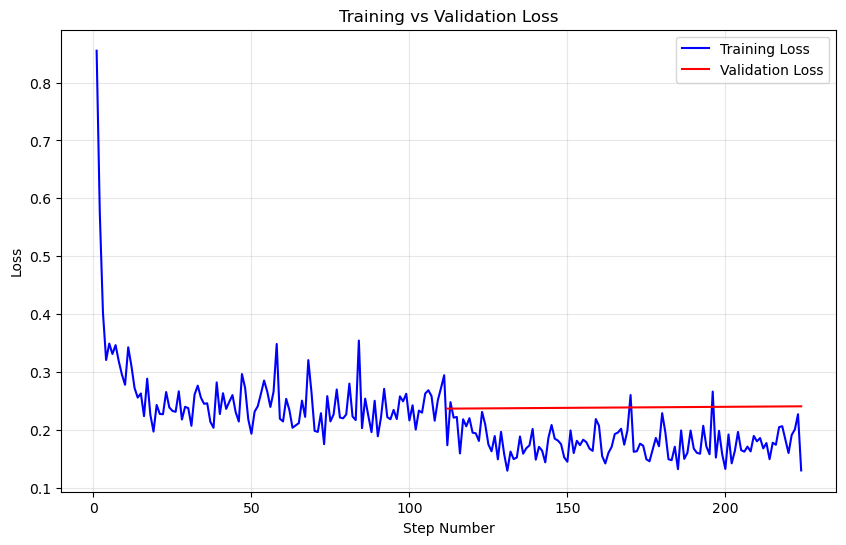

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV files
train_df = pd.read_csv('./tmp/train_output/step_wise_training_metrics.csv')
val_df = pd.read_csv('./tmp/train_output/validation_metrics.csv')

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_df['step_number'], train_df['training_loss'], label='Training Loss', color='blue')
plt.plot(val_df['step_number'], val_df['validation_loss'], label='Validation Loss', color='red')

plt.xlabel('Step Number')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

***

## Step 3: Offline Model evaluation

The purpose of the evaluation process is to assess trained-model performance against benchmarks or custom dataset. The evaluation process typically involves steps to create evaluation recipe pointing to the trained model, specify evaluation datasets and metrics, submit a separate training job for the evaluation, and evaluate against standard benchmarks or custom data. The evaluation process will output performance metrics stored in your Amazon S3 bucket.

Create minimal recipe for `gen_qa` evaluation. With `gen_qa` evaluation, we bring our own dataset for evaluation, and measure the following metrics:

* rouge1
* rouge2
* rougeL
* exact_match
* quasi_exact_match
* f1_score
* f1_score_quasi
* bleu

In [85]:
recipe_job_name = "nova-micro-gen_qa-eval-job"

recipe_content = f"""
run:
  name: {recipe_job_name}
  model_type: amazon.nova-micro-v1:0:128k
  model_name_or_path: {escrow_model_uri}
  data_s3_path: "" # Empty string

evaluation:
  task: gen_qa
  strategy: gen_qa
  metric: all

inference:
  max_new_tokens: 4096
  top_p: 0.9
  temperature: 0.1
"""

with open("eval-recipe.yaml", "w") as f:
  f.write(recipe_content)

### Instance count and Instance Type

Defines the Instance type and count to use for Evaluation 

In [86]:
instance_type = "ml.g5.12xlarge" # Override the instance type if you want to get a different container version
instance_count = 1

instance_type

'ml.g5.12xlarge'

#### Image URI for Evaluation

This specifies the pre-built container for Evaluation, which is different from the SFT container.


In [87]:
image_uri = f"708977205387.dkr.ecr.{sess.boto_region_name}.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-latest"

image_uri

'708977205387.dkr.ecr.us-east-1.amazonaws.com/nova-evaluation-repo:SM-TJ-Eval-latest'

#### Configuring the Model and Recipe

This specifies which model evaluation to use.


In [88]:
model_id = "nova-micro/prod"
recipe = "./eval-recipe.yaml"

#### PyTorch Estimator

This creates a PyTorch estimator with the configuration to run the evaluation job.


In [89]:
from sagemaker.pytorch import PyTorch

# define Training Job Name
job_name = f"train-{model_id.split('/')[0].replace('.', '-')}-peft-sft-eval"

# define OutputDataConfig path
if default_prefix:
    output_path = f"s3://{bucket_name}/{default_prefix}/{job_name}"
else:
    output_path = f"s3://{bucket_name}/{job_name}"
    
recipe_overrides = {
    "run": {
        "replicas": instance_count,  # Required
    },
}

eval_estimator = PyTorch(
    output_path=output_path,
    base_job_name=job_name,
    role=role,
    disable_profiler=True,
    debugger_hook_config=False,
    instance_count=instance_count,
    instance_type=instance_type,
    training_recipe=recipe,
    sagemaker_session=sess,
    image_uri=image_uri
)

### Configuring the Data Channel

In [90]:
from sagemaker.inputs import TrainingInput

eval_input = TrainingInput(
    s3_data=test_dataset_s3_path,
    distribution="FullyReplicated",
    s3_data_type="S3Prefix",
)

### Starting the Training Job
This starts the training job with the configured estimator and datasets. Note that it uses the test dataset for validation during training.


In [91]:
# starting the train job with our uploaded datasets as input
eval_estimator.fit(inputs={"train": eval_input}, wait=False)

INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: train-nova-micro-peft-sft-eval-2025-07-09-05-09-19-603


### Viewing the Evaluation Artifacts 
Downloading the artifact from Evaluation. 


In [ ]:
output = eval_estimator.model_data

In [ ]:
output = '/'.join(output.split("/")[:-1]) +"/output.tar.gz"

In [ ]:
! aws s3 cp $output .

### Visualize results

The notebook defines a function to visualize the evaluation metrics in a bar chart:


In [ ]:
import tarfile
import os
tarfile.open('output.tar.gz', 'r:gz').extractall('output_folder')

In [ ]:
results_path = "output_folder/" + recipe_job_name +"/eval_results"

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os


def plot_metrics(results):
    # Extract metrics and their standard errors
    metrics = {}
    for key, value in results.items():
        if not key.endswith("_stderr"):
            metrics[key] = {"value": value, "stderr": results.get(f"{key}_stderr", 0)}

    # Sort metrics by value for better visualization
    sorted_metrics = dict(
        sorted(metrics.items(), key=lambda x: x[1]["value"], reverse=True)
    )

    # Prepare data for plotting
    labels = list(sorted_metrics.keys())
    values = [sorted_metrics[label]["value"] for label in labels]
    errors = [sorted_metrics[label]["stderr"] for label in labels]

    # Normalize BLEU score to be on the same scale as other metrics (0-1)
    bleu_index = labels.index("bleu") if "bleu" in labels else -1
    if bleu_index >= 0:
        values[bleu_index] /= 100
        errors[bleu_index] /= 100

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create bar chart
    x = np.arange(len(labels))
    bars = ax.bar(
        x,
        values,
        yerr=errors,
        align="center",
        alpha=0.7,
        capsize=5,
        color="skyblue",
        ecolor="black",
    )

    # Add labels and title
    ax.set_ylabel("Score")
    ax.set_title("Evaluation Metrics")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_ylim(0, 1.0)

    # Add value labels on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        # Convert BLEU back to its original scale for display
        display_value = values[i] * 100 if labels[i] == "bleu" else values[i]
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.01,
            f"{display_value:.2f}",
            ha="center",
            va="bottom",
        )

    # Add a note about BLEU
    if bleu_index >= 0:
        ax.text(
            0.5,
            -0.15,
            "Note: BLEU score shown as percentage (original: {:.2f})".format(
                values[bleu_index] * 100
            ),
            transform=ax.transAxes,
            ha="center",
            fontsize=9,
        )

    plt.tight_layout()
    return fig

In [ ]:
import glob
import os

def find_json_files(path):
    return glob.glob(os.path.join(path, "*.json"))

In [ ]:
evaluation_results_path = find_json_files(results_path)[0]

In [ ]:
import json

with open(evaluation_results_path, "r") as f:
    data = json.load(f)

fig = plot_metrics(data["results"]["all"])

output_file = os.path.join("./", 'evaluation_metrics.png')
fig.savefig(output_file, bbox_inches='tight')

***

## Model deployment and inference

After training and evaluating our model, we want to make it available for inference. Amazon Bedrock provides a serverless endpoint for model deployment, allowing us to serve the model without managing infrastructure.

The Bedrock Custom Model feature of Amazon Bedrock lets us import our fine-tuned model and access it through the same API as other foundation models. This provides:

In [ ]:
import boto3

# Initialize the Bedrock client
bedrock = boto3.client("bedrock", region_name=sess.boto_region_name)


model_path = escrow_model_uri

# Define name for imported model
imported_model_name = "nova-lite-sagemaker-sft"

### Creating the Bedrock Custom Model

In [ ]:
request_params = {
    "modelName": imported_model_name,
    "modelSourceConfig": {"s3DataSource": {"s3Uri": model_path}},
    "roleArn": role,
    "clientRequestToken": "NovaRecipeSageMaker",
}

# Create the model import job
response = bedrock.create_custom_model(**request_params)

model_arn = response["modelArn"]

# Output the model ARN
print(f"Model import job created with ARN: {model_arn}")

### Monitoring the Model status

After initiating the model import, we need to monitor its progress. The status goes through several states:

* CREATING: Model is being imported
* ACTIVE: Import successful
* FAILED: Import encountered errors

This cell polls the Bedrock API every 60 seconds to check the status of the model import, continuing until it reaches a terminal state (ACTIVE or FAILED). Once the import completes successfully, we'll have the model ARN which we can use for inference.

In [ ]:
from IPython.display import clear_output
import time

# Check CMI job status
while True:
    response = bedrock.list_custom_models(sortBy='CreationTime',sortOrder='Descending')
    model_summaries = response["modelSummaries"]
    status = ""
    for model in model_summaries:
        if model["modelName"] == imported_model_name:
            status = model["modelStatus"].upper()
            model_arn = model["modelArn"]
            print(f'{model["modelStatus"].upper()} {model["modelArn"]} ...')
            if status in ["ACTIVE", "FAILED"]:
                break
    if status in ["ACTIVE", "FAILED"]:
        break
    clear_output(wait=True)
    time.sleep(10)
    
model_arn

##### ⚠️ After the model is ACTIVE, create provisioned throughput before running the inference!

Please refer to the official [AWS Documentation](https://docs.aws.amazon.com/bedrock/latest/userguide/prov-thru-purchase.html)

### Testing the Deployed Model

Now that our model is deployed to Amazon Bedrock, we can invoke it for inference. We'll set up the necessary clients and functions to interact with our model through the Bedrock Runtime API.

Inference Setup Components:
* Bedrock Runtime Client: AWS SDK client for making inference calls
* Helper Function: To handle retry logic and properly format requests
The generate function we're defining:

Applies the proper chat template to user messages
* Handles retry logic for robustness
* Sets appropriate generation parameters like temperature and top-p

This setup allows us to easily test how well our training worked by sending queries to the model and evaluating its responses.

In [ ]:
import boto3
from botocore.config import Config


# Initialize Bedrock Runtime client
session = boto3.Session()
client = session.client(
    service_name="bedrock-runtime",
    region_name=sess.boto_region_name,
    config=Config(
        connect_timeout=300,  # 5 minutes
        read_timeout=300,  # 5 minutes
        retries={"max_attempts": 3},
    ),
)

In [ ]:
def generate(
    model_id,
    messages,
    system_prompt=None,
    tools=None,
    temperature=0.3,
    max_tokens=4096,
    top_p=0.9,
    max_retries=10,
):
    """
    Generate response using the model with proper tokenization and retry mechanism

    Parameters:
        model_id (str): ID of the model to use
        messages (list): List of message dictionaries with 'role' and 'content'
        system_prompt (str, optional): System prompt to guide the model
        tools (dict, optional): Tool configuration for the model
        temperature (float): Controls randomness in generation (0.0-1.0)
        max_tokens (int): Maximum number of tokens to generate
        top_p (float): Nucleus sampling parameter (0.0-1.0)
        max_retries (int): Maximum number of retry attempts

    Returns:
        dict: Model response containing generated text and metadata
    """
    # Prepare base parameters for the API call
    kwargs = {
        "inferenceConfig": {
            "temperature": temperature,
            "maxTokens": max_tokens,
            "topP": top_p,
        },
    }

    # Add optional parameters if provided
    if tools:
        kwargs["toolConfig"] = tools
    if system_prompt:
        kwargs["system"] = [{"text": system_prompt}]

    # Retry logic
    for attempt in range(max_retries):
        try:
            return client.converse(modelId=model_id, messages=messages, **kwargs)
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(30)
            else:
                print("Max retries reached. Unable to get response.")
                print(str(e))
                return None

In [ ]:
import json

model_arn = "<PROVISIONED_THROUGHPUT_ARN>"

system_prompt = f"""
You are a helpful AI assistant that can answer questions and provide information.
You can use tools to help you with your tasks.

You have access to the following tools:

<tools>
{{tools}}
</tools>
For each function call, return a json object with function name and parameters:

{{{{\"name\": \"function name\", \"parameters\": \"dictionary of argument name and its value\"}}}}
"""

tools = [
    {
        "toolSpec": {
            "name": "calculate_bmi",
            "description": "Calculate BMI given weight in kg and height in meters",
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "weight_kg": {
                            "type": "number",
                            "description": "Property weight_kg",
                        },
                        "height_m": {
                            "type": "number",
                            "description": "Property height_m",
                        },
                    },
                    "required": ["weight_kg", "height_m"],
                },
            },
        }
    },
    {
        "toolSpec": {
            "name": "fetch_weather",
            "description": 'Fetch weather information\n\nArgs:\nquery: The weather query (e.g., "weather in New York")\nnum_results: Number of results to return (default: 1)\n\nReturns:\nJSON string containing weather information',
            "inputSchema": {
                "json": {
                    "type": "object",
                    "properties": {
                        "type": "object",
                        "properties": {
                            "query": {
                                "type": "string",
                                "description": "Property query",
                            },
                            "num_results": {
                                "type": "integer",
                                "description": "Property num_results",
                            },
                        },
                        "required": ["query"],
                    },
                },
            },
        }
    },
]

system_prompt = system_prompt.format(tools=json.dumps({"tools": tools}))

messages = [
    {"role": "user", "content": [{"text": "What is the weather in Rome, Italy?"}]},
]

response = generate(
    model_id=model_arn,
    system_prompt=system_prompt,
    messages=messages,
    temperature=0.1,
    top_p=0.9,
)

response["output"]